In [ ]:
# advance neuro project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import torch

In [2]:
# select the device to run the code on
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu" 

In [3]:
def ReLU(x):
    zeros_mat = torch.zeros(x.shape, device=dev)
    output = torch.fmax(x, zeros_mat)
    return output

In [4]:
def ReLU_deriv(x):
    non_negs = torch.where(x >= 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1
    return output

In [5]:
def angleCal(A, B):
    num = torch.trace(torch.matmul(torch.conj(A.T), B))
    norm_A = math.sqrt(torch.trace(torch.matmul(A,torch.conj(A.T))))
    norm_B = math.sqrt(torch.trace(torch.matmul(B,torch.conj(B.T))))
    denum = norm_A*norm_B
    angle = torch.arccos(num/denum)*180/math.pi
    return angle

In [ ]:
#### network parameters - open loop 2 layer network - first condition - auto correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles1 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)
    
    # input layer values - # move on gpu
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    
    for j in range (number_of_iterations):
        angles1[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


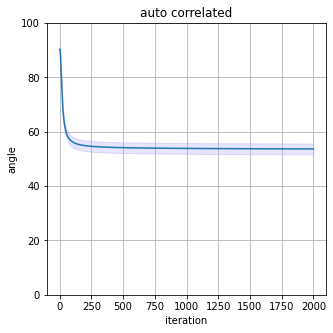

In [ ]:
## plot the result of auto correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5));
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0));
ax.set_ylim([0, 100]);
ax.set_title('auto correlated');
ax.set_ylabel('angle');
ax.set_xlabel('iteration');
ax.grid(True);

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - second condition - cross correlated 

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles2 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.clone(input_layer) # cross correlated with inputs of network
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
    
    for j in range (number_of_iterations):
        angles2[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = torch.clone(error_delta2)
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.clone(input_layer)
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


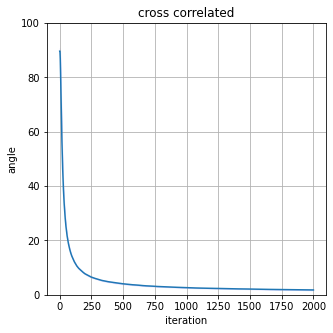

In [ ]:
# plot the result of cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - third condition - not auto correlated nor cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles3 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta2 = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
    error_delta1 = torch.matmul(error_delta2, backward_weight_1)

    for j in range (number_of_iterations):
        angles3[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(forward_weight_0.T, input_layer.T).T
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        # generate the parameters again
        input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) 
        error_delta2 = torch.normal(mu, sigma, size=(n_b, output_layer_size), device=dev) 
        error_delta1 = torch.matmul(error_delta2, backward_weight_1) 
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


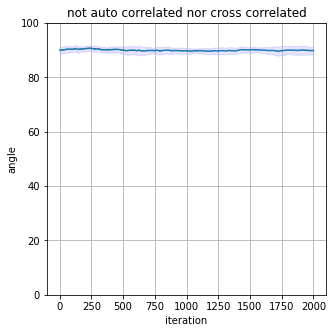

In [ ]:
# plot the result of not auto correlated nor cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('not auto correlated nor cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


In [ ]:
#### network parameters - open loop 2 layer network - forth condition - auto correlated & cross correlated

mu = 0
sigma = 1
LR = 0.002
n_b = 100 # batch size
number_of_iterations = 2000


input_layer_size = 20
hidden_layer1_size = 100
output_layer_size = 20

# updating the network parameters
epoch_num = 10
angles4 = torch.zeros((epoch_num, number_of_iterations), device=dev)

for k in range (epoch_num):
    forward_weight_0 = torch.normal(mu, sigma, size=(input_layer_size,hidden_layer1_size), device=dev)
    forward_weight_1 = torch.normal(mu, sigma, size=(hidden_layer1_size,output_layer_size), device=dev)
    backward_weight_1 = torch.normal(mu, sigma, size=(output_layer_size,hidden_layer1_size), device=dev)

    # input layer values
    input_layer = torch.normal(mu, sigma, size=(n_b, input_layer_size), device=dev) # initial value of inputs - constant during iterations
    error_delta2 = input_layer # initial value of error_delta 2 - constant during iterations
    error_delta1 = torch.matmul(error_delta2, backward_weight_1) # initial value of error_delta1 - constant during iterations since
    # delta 2 doesn't change

    for j in range (number_of_iterations):
        angles4[k,j] = angleCal(forward_weight_1, backward_weight_1.T)
        Z1 = torch.matmul(input_layer, forward_weight_0)
        hidden_layer_1 = ReLU(Z1)
        delta1 = torch.multiply(error_delta1,ReLU_deriv(Z1))
        delta_w0 = LR*torch.matmul(input_layer.T, delta1)
        delta2 = error_delta2
        delta_w1 = LR*torch.matmul(hidden_layer_1.T, delta2)
        forward_weight_0 += delta_w0
        forward_weight_1 += delta_w1
        
print('simulation finished, please run the next section for the result')

simulation finished, please run the next section for the result


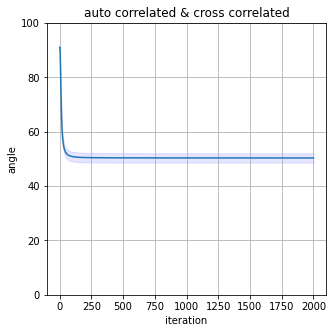

In [ ]:
# plot the result of auto correlated & cross correlated mode(prev part's result)

    
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('auto correlated & cross correlated')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)

# plot the condfidence interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='b', alpha=.1);


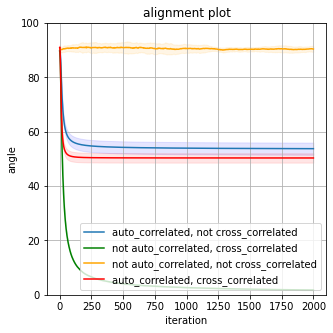

In [ ]:
# plot the result of all three conditions together

    
fig, ax = plt.subplots(1,1,figsize=(5,5))

# condition 1
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles1.cpu().numpy(),0))
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence1 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles1.cpu().numpy(),0)-np.std(angles1.cpu().numpy(),axis=0),\
                np.mean(angles1.cpu().numpy(),0)+np.std(angles1.cpu().numpy(),axis=0),\
                color='b', alpha=.1);

# condition 2
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles2.cpu().numpy(),0),color='green')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence2 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles2.cpu().numpy(),0)-np.std(angles2.cpu().numpy(),axis=0),\
                np.mean(angles2.cpu().numpy(),0)+np.std(angles2.cpu().numpy(),axis=0),\
                color='green', alpha=.1);

# condition 3
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles3.cpu().numpy(),0),color='orange')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence3 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles3.cpu().numpy(),0)-np.std(angles3.cpu().numpy(),axis=0),\
                np.mean(angles3.cpu().numpy(),0)+np.std(angles3.cpu().numpy(),axis=0),\
                color='orange', alpha=.1);

# condition 4
ax.plot(np.arange(1,number_of_iterations+1),np.mean(angles4.cpu().numpy(),0),color='red')
ax.set_ylim([0, 100])
ax.set_title('alignment plot')
ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.grid(True)
# plot the condfidence4 interval over repeations
ax.fill_between(np.arange(1,number_of_iterations+1),\
                np.mean(angles4.cpu().numpy(),0)-np.std(angles4.cpu().numpy(),axis=0),\
                np.mean(angles4.cpu().numpy(),0)+np.std(angles4.cpu().numpy(),axis=0),\
                color='red', alpha=.1);

ax.legend(['auto_correlated, not cross_correlated','not auto_correlated, cross_correlated',\
           'not auto_correlated, not cross_correlated',\
          'auto_correlated, cross_correlated'],loc='lower right')

In [ ]:
# Paper Part - 2.3 Using the provided theoretical tool to investigate FA in the learning process of a practical deep ANN
# train and test a 5 layer network on MNIST
# fact = tanh(ReLU) - 50 neurons in all hidden and output layer - output layer is using 5 hot coding
# images of MNIST should be resized to 15*15 - so we have 225 neurons in input layer 
# inputs should be normalized 
# batch size = 1000, 60 batches available (total numbre of 60K images)
# initialization of forward/ backward weights and biases is done using N(0,0.1)
# loss function is sth like squared error, check page 5 for the details

In [6]:
def n_hot_coder(x,n,hot_labels,output_neuron_num):
    labels = x.cpu().numpy()
    category_num = 10
    if(category_num*n > output_neuron_num):
        print('nhot encoding can`t be done since the condition`s not met')
        return False
    
    output = torch.zeros((len(x),output_neuron_num), device=dev)
    
    output[np.where(labels == 0),:] = hot_labels[0,:]
    output[np.where(labels == 1),:] = hot_labels[1,:]
    output[np.where(labels == 2),:] = hot_labels[2,:]
    output[np.where(labels == 3),:] = hot_labels[3,:]
    output[np.where(labels == 4),:] = hot_labels[4,:]
    output[np.where(labels == 5),:] = hot_labels[5,:]
    output[np.where(labels == 6),:] = hot_labels[6,:]
    output[np.where(labels == 7),:] = hot_labels[7,:]
    output[np.where(labels == 8),:] = hot_labels[8,:]
    output[np.where(labels == 9),:] = hot_labels[9,:]

    return output

In [7]:
def loss_function(output_layer,labels):
    difference = labels-output_layer
    output = 0.5*(torch.sum(difference**2))
    return output

In [8]:
def tanh_Relu_deriv(x):
    non_negs = torch.where(x > 0)
    output = torch.zeros(x.shape, device=dev)
    output[non_negs] = 1-torch.tanh(x[non_negs])**2
    return output

In [9]:
def binarize_output(output,n,categories_nhot):
  
    binarized = torch.zeros((output.shape[0],output.shape[1]), device=dev)
    current_data_scores = torch.matmul(output,categories_nhot.T)
    _, closest_label = torch.max(current_data_scores,dim=1)
    binarized = categories_nhot[closest_label,:]
    
    return binarized

In [10]:
def accuracy_cal(output,label):
    acc = 0
    
    compare = output.shape[1]*torch.ones((output.shape[0]), device=dev)
    acc = torch.sum(torch.eq(torch.sum(torch.eq(output,label),dim=1),compare))
  
    acc = acc/len(output)*100 # in percentage
    return acc

In [29]:
def alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime,delta4_inTime,delta3_inTime,\
                      delta2_inTime,delta1_inTime,input_layer,hidden_layer1_inTime,hidden_layer2_inTime,\
                      hidden_layer3_inTime,hidden_layer4_inTime):

    alignment_terms = [];
    
    
    # cal alignment terms
    for i in range(1,iter_needed): # iteration
      if(i == 65 or i == 179):
          print(i)
          o = 0
          torch.cuda.empty_cache()
          alignment_terms_k = torch.zeros((i,layer_num,output_layer_size,output_layer_size), device=dev)
          while (o < i):
              # l1
              alignment_terms_k[o,0,:,:] = (LR**2)*torch.chain_matmul(B1.T,delta2_inTime[i-o-1,:,:].T,\
                                                                      input_layer[np.mod(i-o-1,batch_num),:,:],input_layer[np.mod(i,batch_num),:,:].T,\
                                                                      delta2_inTime[i,:,:])
              # l2
              alignment_terms_k[o,1,:,:] = (LR**2)*torch.chain_matmul(B2.T,delta3_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer1_inTime[i,:,:],hidden_layer1_inTime[i,:,:].T,\
                                                                      delta3_inTime[i,:,:])
              # l3
              alignment_terms_k[o,2,:,:] = (LR**2)*torch.chain_matmul(B3.T,delta4_inTime[i-o-1,:,:].T,\
                                                                      hidden_layer2_inTime[i,:,:],hidden_layer2_inTime[i,:,:].T,\
                                                                      delta4_inTime[i,:,:])
              # l4
              alignment_terms_k[o,3,:,:] = (LR**2)*torch.chain_matmul(B4.T,delta5_inTime[i-o-1,:,:].T,\
                                                                hidden_layer3_inTime[i,:,:],hidden_layer3_inTime[i,:,:].T,\
                                                                delta4_inTime[i,:,:])
              
              o += 1
          
          alignment_terms.append(alignment_terms_k)
        
    return alignment_terms

In [12]:
def create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                   hidden_layer3_size,hidden_layer4_size,output_layer_size):

  # forward weights
  w0 = torch.normal(mu,sigma,size=(input_layer_size,hidden_layer1_size), device=dev)
  w1 = torch.normal(mu,sigma,size=(hidden_layer1_size,hidden_layer2_size), device=dev)
  w2 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer3_size), device=dev)
  w3 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer4_size), device=dev)
  w4 = torch.normal(mu,sigma,size=(hidden_layer4_size,output_layer_size), device=dev)

  # backward weights
  B4 = torch.normal(mu,sigma,size=(output_layer_size,hidden_layer4_size), device=dev)
  B3 = torch.normal(mu,sigma,size=(hidden_layer4_size,hidden_layer3_size), device=dev)
  B2 = torch.normal(mu,sigma,size=(hidden_layer3_size,hidden_layer2_size), device=dev)
  B1 = torch.normal(mu,sigma,size=(hidden_layer2_size,hidden_layer1_size), device=dev)

  # bias vectors
  b1 =  torch.normal(mu,sigma,size=(1,hidden_layer1_size), device=dev)
  b2 =  torch.normal(mu,sigma,size=(1,hidden_layer2_size), device=dev)
  b3 =  torch.normal(mu,sigma,size=(1,hidden_layer3_size), device=dev)
  b4 =  torch.normal(mu,sigma,size=(1,hidden_layer4_size), device=dev)
  b5 =  torch.normal(mu,sigma,size=(1,output_layer_size), device=dev)

  print('network parameters created!')

  return w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5


In [13]:
# Load MNIST Dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist

# loading the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert images to pytorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train)
x_test = torch.from_numpy(x_test)
y_test = torch.from_numpy(y_test)

print('data loaded!')
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


11501568/11490434 [==============================] - 0s 0us/step
data loaded!
torch.Size([60000, 28, 28]) torch.Size([60000]) torch.Size([10000, 28, 28]) torch.Size([10000])


In [14]:
# resize images to 15*15
from torchvision import transforms as trans
import torchvision.transforms.functional as Func

x_train_resized = torch.zeros((x_train.shape[0],15,15))
x_test_resized = torch.zeros((x_test.shape[0],15,15))
resize_trans = trans.Resize(15)

# resize train images
for i in range (x_train.shape[0]):
    image = x_train[i,:,:].unsqueeze(0)
    x_train_resized[i,:,:] = resize_trans(image)

    
# resize test images
for i in range (x_test.shape[0]):
    image = x_test[i,:,:].unsqueeze(0)
    x_test_resized[i,:,:] = resize_trans(image)
    
print('resizing done!')
print(x_train_resized.shape,x_test_resized.shape)


resizing done!
torch.Size([60000, 15, 15]) torch.Size([10000, 15, 15])


In [15]:
# convert images and labels to pytorch tensors & vectorize them

x_train_flat = x_train_resized.reshape(x_train_resized.shape[0],-1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0],-1)

x_train_flat = x_train_flat.to(dev)
x_test_flat = x_test_flat.to(dev)
y_train = y_train.to(dev)
y_test = y_test.to(dev)

print('vectorization done!')
print(x_train_flat.shape,x_test_flat.shape)

vectorization done!
torch.Size([60000, 225]) torch.Size([10000, 225])


In [16]:
# normalize images

x_tr_norm = x_train_flat/255
x_te_norm  = x_test_flat/255


print('normalization done!')

normalization done!


In [17]:
# n hot coding the labels
category_num = 10
output_neuron_num = 50
n = int(output_neuron_num/category_num)

# encoding the categroies
categories_nhot = torch.zeros((category_num,output_neuron_num), device=dev)
codes = torch.randperm(output_neuron_num, device=dev)

for i in range(category_num):
    categories_nhot[i,codes[i*n:(i+1)*n]] = 1 
    
y_train_nhot = n_hot_coder(y_train,n,categories_nhot,output_neuron_num)
y_test_nhot = n_hot_coder(y_test,n,categories_nhot,output_neuron_num)

print('n hot coding done!')
print(y_train_nhot.shape, y_test_nhot.shape)


n hot coding done!
torch.Size([60000, 50]) torch.Size([10000, 50])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  # Remove the CWD from sys.path while we load stuff.


In [18]:
# create the network weights and biases from N(mu,sigma)
mu = 0
sigma = 0.1

# each layer size
input_layer_size = 225
hidden_layer1_size = 50
hidden_layer2_size = 50
hidden_layer3_size = 50
hidden_layer4_size = 50
output_layer_size = 50

w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                   hidden_layer3_size,hidden_layer4_size,output_layer_size)



network parameters created!


In [32]:
import pandas as pd
import gc

gc.collect()
# run the network - run prev part to initialize the paramters each time

LR = 0.0005
batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
epoch_num = 100
run_num = 30


accuracy_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)
loss_training = torch.zeros((run_num,batch_num,epoch_num), device=dev)

# angle between B & W
alignment = torch.zeros((run_num,4,batch_num,epoch_num), device=dev)


# layer and delta values in iterations for calculating alignment terms
iter_needed = 180
hidden_layer1_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer1_size), device=dev)
hidden_layer2_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer2_size), device=dev)
hidden_layer3_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer3_size), device=dev)
hidden_layer4_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer4_size), device=dev)
output_layer_inTime = torch.zeros((run_num,iter_needed,batch_size,output_layer_size), device=dev)
delta5_inTime = torch.zeros((run_num,iter_needed,batch_size,output_layer_size), device=dev)
delta4_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer4_size), device=dev)
delta3_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer3_size), device=dev)
delta2_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer2_size), device=dev)
delta1_inTime = torch.zeros((run_num,iter_needed,batch_size,hidden_layer1_size), device=dev)



for k in range(run_num):
  print('run ', k, ' ...')

  # create network parameters
  w0, w1, w2, w3, w4, B4, B3, B2, B1, b1, b2, b3, b4, b5 = \
  create_network(mu,sigma,input_layer_size,hidden_layer1_size,hidden_layer2_size,\
                    hidden_layer3_size,hidden_layer4_size,output_layer_size)


  for j in range(epoch_num):
      torch.cuda.empty_cache()

      for i in range(batch_num):
          # forward
          z1 = torch.matmul(input_layer[i,:,:],w0) + b1
          hidden_layer1 = torch.tanh(ReLU(z1))
          z2 = torch.matmul(hidden_layer1,w1) + b2
          hidden_layer2 = torch.tanh(ReLU(z2))
          z3 = torch.matmul(hidden_layer2,w2) + b3
          hidden_layer3 = torch.tanh(ReLU(z3))
          z4 = torch.matmul(hidden_layer3,w3) + b4
          hidden_layer4 = torch.tanh(ReLU(z4))
          z5 = torch.matmul(hidden_layer4,w4) + b5
          output_layer = torch.tanh(ReLU(z5))
          
          # backward the error
          E = y_train_nhot[i*batch_size:(i+1)*batch_size,:]-output_layer
          delta5 = torch.multiply(E,tanh_Relu_deriv(z5))
          delta4 = torch.multiply(torch.matmul(delta5,B4),tanh_Relu_deriv(z4))
          delta3 = torch.multiply(torch.matmul(delta4,B3),tanh_Relu_deriv(z3))
          delta2 = torch.multiply(torch.matmul(delta3,B2),tanh_Relu_deriv(z2))
          delta1 = torch.multiply(torch.matmul(delta2,B1),tanh_Relu_deriv(z1))
          
          # save values in time for calculating alignment terms - just up to iteration 1260
          if(j*batch_num+i < iter_needed):
              hidden_layer1_inTime[k,j*batch_num+i,:,:] = hidden_layer1
              hidden_layer2_inTime[k,j*batch_num+i,:,:] = hidden_layer2
              hidden_layer3_inTime[k,j*batch_num+i,:,:] = hidden_layer3
              hidden_layer4_inTime[k,j*batch_num+i,:,:] = hidden_layer4
              output_layer_inTime[k,j*batch_num+i,:,:] = output_layer
              delta5_inTime[k,j*batch_num+i,:,:] = delta5
              delta4_inTime[k,j*batch_num+i,:,:] = delta4
              delta3_inTime[k,j*batch_num+i,:,:] = delta3
              delta2_inTime[k,j*batch_num+i,:,:] = delta2
              delta1_inTime[k,j*batch_num+i,:,:] = delta1
              
          
          # update forward weights 
          w4 += LR*torch.matmul(hidden_layer4.T,delta5)
          w3 += LR*torch.matmul(hidden_layer3.T,delta4)
          w2 += LR*torch.matmul(hidden_layer2.T,delta3)
          w1 += LR*torch.matmul(hidden_layer1.T,delta2)
          w0 += LR*torch.matmul(input_layer[i,:,:].T,delta1)
          
          # update biases
          J = torch.ones((1,batch_size), device=dev)
          b5 += torch.squeeze(LR*torch.matmul(J,delta5))
          b4 += torch.squeeze(LR*torch.matmul(J,delta4))
          b3 += torch.squeeze(LR*torch.matmul(J,delta3))
          b2 += torch.squeeze(LR*torch.matmul(J,delta2))
          b1 += torch.squeeze(LR*torch.matmul(J,delta1))
          
          # binarize output
          n = 5 # n hot
          output_layer_binarized = binarize_output(output_layer,n,categories_nhot)

          # loss values
          loss_training[k,i,j] = loss_function(output_layer,y_train_nhot[i*batch_size:(i+1)*batch_size,:])
          accuracy_training[k,i,j] = accuracy_cal(output_layer_binarized,y_train_nhot[i*batch_size:(i+1)*batch_size,:]);
          
          # cal the angle between B & W
          alignment[k,0,i,j] = angleCal(w1,B1.T)
          alignment[k,1,i,j] = angleCal(w2,B2.T) 
          alignment[k,2,i,j] = angleCal(w3,B3.T) 
          alignment[k,3,i,j] = angleCal(w4,B4.T) 
      
      print(torch.mean(accuracy_training[k,:,j]),torch.mean(loss_training[k,:,j]))

print('network training done!')

run  0  ...
network parameters created!
tensor(16.7767, device='cuda:0') tensor(2299.2683, device='cuda:0')
tensor(38.7017, device='cuda:0') tensor(2006.5321, device='cuda:0')
tensor(60.9083, device='cuda:0') tensor(1750.2191, device='cuda:0')
tensor(69.5950, device='cuda:0') tensor(1534.2462, device='cuda:0')
tensor(72.9517, device='cuda:0') tensor(1381.4196, device='cuda:0')
tensor(74.8600, device='cuda:0') tensor(1293.7153, device='cuda:0')
tensor(76.4700, device='cuda:0') tensor(1237.3831, device='cuda:0')
tensor(77.8500, device='cuda:0') tensor(1195.9886, device='cuda:0')
tensor(78.9950, device='cuda:0') tensor(1163.5156, device='cuda:0')
tensor(79.7833, device='cuda:0') tensor(1136.2113, device='cuda:0')
tensor(80.6200, device='cuda:0') tensor(1112.2479, device='cuda:0')
tensor(81.3000, device='cuda:0') tensor(1090.6715, device='cuda:0')
tensor(81.9850, device='cuda:0') tensor(1071.7927, device='cuda:0')
tensor(82.5450, device='cuda:0') tensor(1055.1660, device='cuda:0')
tensor(8

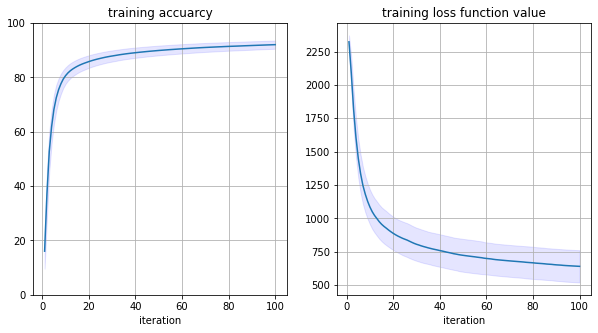

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(np.arange(1,epoch_num+1),np.mean(accuracy_training.cpu().numpy(),axis=(0,1)))
ax[1].plot(np.arange(1,epoch_num+1),np.mean(loss_training.cpu().numpy(),axis=(0,1)))
ax[0].fill_between(np.arange(1,epoch_num+1),\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))-np.std(accuracy_training.cpu().numpy(),axis=(0,1)),\
                np.mean(accuracy_training.cpu().numpy(),axis=(0,1))+np.std(accuracy_training.cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1);
ax[1].fill_between(np.arange(1,epoch_num+1),\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))-np.std(loss_training.cpu().numpy(),axis=(0,1)),\
                np.mean(loss_training.cpu().numpy(),axis=(0,1))+np.std(loss_training.cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1); 
ax[0].set_ylim(0,100)          
ax[0].set_title('training accuarcy')
ax[0].set_xlabel('iteration')
ax[1].set_title('training loss function value')
ax[1].set_xlabel('iteration')
ax[0].grid(True)
ax[1].grid(True)

In [34]:
import pandas as pd

# accuracy on test data

batch_size = 1
batch_num = int(x_te_norm.shape[0]/batch_size)
im_size = 15*15
input_layer = x_te_norm.reshape((batch_num,batch_size,im_size))
accuracy_training = torch.zeros((batch_num), device=dev)
loss_training = torch.zeros((batch_num), device=dev)

for i in range(batch_num):
    # forward
    z1 = torch.matmul(input_layer[i,:,:],w0) + b1
    hidden_layer1 = torch.tanh(ReLU(z1))
    z2 = torch.matmul(hidden_layer1,w1) + b2
    hidden_layer2 = torch.tanh(ReLU(z2))
    z3 = torch.matmul(hidden_layer2,w2) + b3
    hidden_layer3 = torch.tanh(ReLU(z3))
    z4 = torch.matmul(hidden_layer3,w3) + b4
    hidden_layer4 = torch.tanh(ReLU(z4))
    z5 = torch.matmul(hidden_layer4,w4) + b5
    output_layer = torch.tanh(ReLU(z5))

    # binarize output
    n = 5
    output_layer_binarized = binarize_output(output_layer,n,categories_nhot)
    
    # loss val and accuracy
    loss_training[i] = loss_function(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:])
    accuracy_training[i] = accuracy_cal(output_layer_binarized,y_test_nhot[i*batch_size:(i+1)*batch_size,:]);

print('accuracy: ',torch.mean(accuracy_training),' | loss value: ', torch.mean(loss_training))
print('done!')

accuracy:  tensor(92.3700, device='cuda:0')  | loss value:  tensor(0.3815, device='cuda:0')
done!


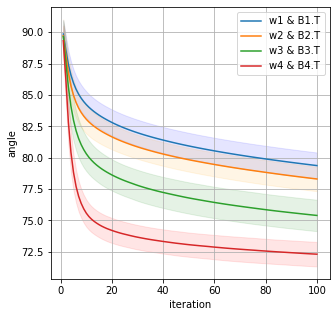

In [35]:
# angle between backward weights and forward weights
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)))
ax.plot(np.arange(1,epoch_num+1),np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)))


ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,0,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,0,:,:].cpu().numpy(),axis=(0,1)),\
                color='blue', alpha=.1); 

ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,1,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,1,:,:].cpu().numpy(),axis=(0,1)),\
                color='orange', alpha=.1);           

ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,2,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,2,:,:].cpu().numpy(),axis=(0,1)),\
                color='green', alpha=.1);     
                
ax.fill_between(np.arange(1,epoch_num+1),\
                np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1))-np.std(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)),\
                np.mean(alignment[:,3,:,:].cpu().numpy(),axis=(0,1))+np.std(alignment[:,3,:,:].cpu().numpy(),axis=(0,1)),\
                color='red', alpha=.1); 


ax.set_ylabel('angle')
ax.set_xlabel('iteration')
ax.legend(['w1 & B1.T','w2 & B2.T','w3 & B3.T','w4 & B4.T'],loc='best')
ax.grid(True)

In [37]:
# alignment terms calculation
import gc

batch_size = 1000
batch_num = 60
layer_num = 4
im_size = 15*15
epoch_num = 100

input_layer = x_tr_norm.reshape((batch_num,batch_size,im_size))
gc.collect()


alignment_terms = [];
for k in range(run_num):
  alignment_terms.append(alignment_term_cal(iter_needed,batch_num,layer_num,LR,B1,B2,B3,B4,delta5_inTime[k,:,:,:],delta4_inTime[k,:,:,:],delta3_inTime[k,:,:,:],\
                        delta2_inTime[k,:,:,:],delta1_inTime[k,:,:,:],input_layer,hidden_layer1_inTime[k,:,:,:],hidden_layer2_inTime[k,:,:,:],\
                        hidden_layer3_inTime[k,:,:,:],hidden_layer4_inTime[k,:,:,:]))


65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179
65
179


In [38]:
# cal angles between alignment terms and backwart weights.T
angles_alignment_terms = np.zeros((len(alignment_terms),len(alignment_terms[0]),len(alignment_terms[-1][0]),4))
print(angles_alignment_terms.shape)

for j in range(len(alignment_terms)):
  for k in range(len(alignment_terms[0])):
    T_k = alignment_terms[j][k]
    print(T_k.shape)
    for i in range(65):
        T_o = np.squeeze(T_k[i,:,:,:])
        angles_alignment_terms[j,k,i,0] = angleCal(T_o[0,:,:],B1.T)
        angles_alignment_terms[j,k,i,1] = angleCal(T_o[1,:,:],B2.T)
        angles_alignment_terms[j,k,i,2] = angleCal(T_o[2,:,:],B3.T)
        angles_alignment_terms[j,k,i,3] = angleCal(T_o[3,:,:],B4.T)


(30, 2, 65, 4)
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 4, 50, 50])
torch.Size([179, 4, 50, 50])
torch.Size([65, 

(30, 2, 65, 4)


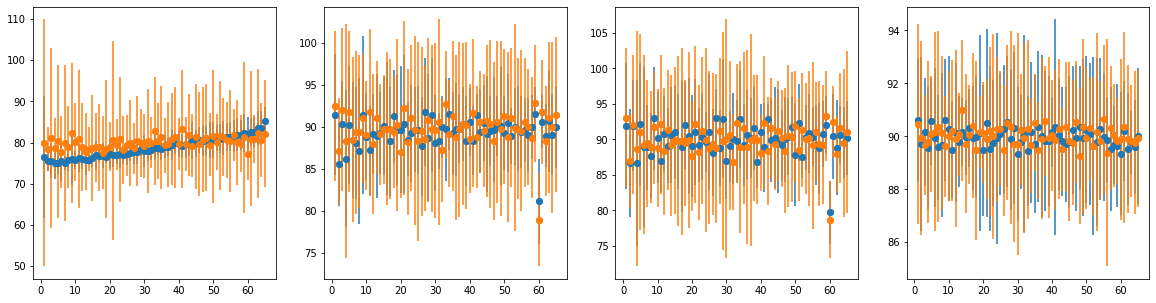

In [39]:
print(angles_alignment_terms.shape)
fig, ax = plt.subplots(1,4,figsize=(20,5))

# mean
ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,0],axis=0))
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,1],axis=0))
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,2],axis=0))
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,3],axis=0))


ax[0].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,0],axis=0))
ax[1].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,1],axis=0))
ax[2].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,2],axis=0))
ax[3].scatter(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,3],axis=0))

# errorbars
ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,0],axis=0), yerr=np.var(angles_alignment_terms[:,0,0:65,0],axis=0), fmt="o")
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,1],axis=0), yerr=np.var(angles_alignment_terms[:,0,0:65,1],axis=0), fmt="o")
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,2],axis=0), yerr=np.var(angles_alignment_terms[:,0,0:65,2],axis=0), fmt="o")
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,0,0:65,3],axis=0), yerr=np.var(angles_alignment_terms[:,0,0:65,3],axis=0), fmt="o")

ax[0].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,0],axis=0), yerr=np.var(angles_alignment_terms[:,1,0:65,0],axis=0), fmt="o")
ax[1].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,1],axis=0), yerr=np.var(angles_alignment_terms[:,1,0:65,1],axis=0), fmt="o")
ax[2].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,2],axis=0), yerr=np.var(angles_alignment_terms[:,1,0:65,2],axis=0), fmt="o")
ax[3].errorbar(np.arange(1,66),np.mean(angles_alignment_terms[:,1,0:65,3],axis=0), yerr=np.var(angles_alignment_terms[:,1,0:65,3],axis=0), fmt="o")


plt.show()

ax[0].legend(['k=66','k=1260'])
